https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.2 MB/s eta 0:00:00


In [3]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
%matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


Because BERT is a pretrained model that expects input data in a specific format, we will need:

A special token, [SEP], to mark the end of a sentence, or the separation between two sentences
A special token, [CLS], at the beginning of our text. This token is used for classification tasks, but BERT expects it no matter what your application is.
Tokens that conform with the fixed vocabulary used in BERT
The Token IDs for the tokens, from BERT’s tokenizer
Mask IDs to indicate which elements in the sequence are tokens and which are padding elements
Segment IDs used to distinguish different sentences
Positional Embeddings used to show token position within the sequence

2.1. Special Tokens
BERT can take as input either one or two sentences, and uses the special token [SEP] to differentiate them. The [CLS] token always appears at the start of the text, and is specific to classification tasks.

Both tokens are always required, however, even if we only have one sentence, and even if we are not using BERT for classification. That’s how BERT was pre-trained, and so that’s what BERT expects to see.

2 Sentence Input:

[CLS] The man went to the store. [SEP] He bought a gallon of milk.

1 Sentence Input:

[CLS] The man went to the store. [SEP]

2.2. Tokenization
BERT provides its own tokenizer, which we imported above. Let’s see how it handles the below sentence.

In [4]:
text = "Here is the sentence I want embeddings for."
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.', '[SEP]']


The original word has been split into smaller subwords and characters. The two hash signs preceding some of these subwords are just our tokenizer’s way to denote that this subword or character is part of a larger word and preceded by another subword. So, for example, the ‘##bed’ token is separate from the ‘bed’ token; the first is used whenever the subword ‘bed’ occurs within a larger word and the second is used explicitly for when the standalone token ‘thing you sleep on’ occurs.

Why does it look this way? This is because the BERT tokenizer was created with a WordPiece model. This model greedily creates a fixed-size vocabulary of individual characters, subwords, and words that best fits our language data. Since the vocabulary limit size of our BERT tokenizer model is 30,000, the WordPiece model generated a vocabulary that contains all English characters plus the ~30,000 most common words and subwords found in the English language corpus the model is trained on. This vocabulary contains four things:

Whole words
Subwords occuring at the front of a word or in isolation (“em” as in “embeddings” is assigned the same vector as the standalone sequence of characters “em” as in “go get em” )
Subwords not at the front of a word, which are preceded by ‘##’ to denote this case
Individual characters
To tokenize a word under this model, the tokenizer first checks if the whole word is in the vocabulary. If not, it tries to break the word into the largest possible subwords contained in the vocabulary, and as a last resort will decompose the word into individual characters. Note that because of this, we can always represent a word as, at the very least, the collection of its individual characters.

As a result, rather than assigning out of vocabulary words to a catch-all token like ‘OOV’ or ‘UNK,’ words that are not in the vocabulary are decomposed into subword and character tokens that we can then generate embeddings for.

So, rather than assigning “embeddings” and every other out of vocabulary word to an overloaded unknown vocabulary token, we split it into subword tokens [‘em’, ‘##bed’, ‘##ding’, ‘##s’] that will retain some of the contextual meaning of the original word. We can even average these subword embedding vectors to generate an approximate vector for the original word.

(For more information about WordPiece, see the original paper and further disucssion in Google’s Neural Machine Translation System.)

Here are some examples of the tokens contained in our vocabulary. Tokens beginning with two hashes are subwords or individual characters.



In [5]:
list(tokenizer.vocab.keys())[5000:5020]

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes']

After breaking the text into tokens, we then have to convert the sentence from a list of strings to a list of vocabulary indeces.

From here on, we’ll use the below example sentence, which contains two instances of the word “bank” with different meanings.

In [6]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))


[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


Segment ID
BERT is trained on and expects sentence pairs, using 1s and 0s to distinguish between the two sentences. That is, for each token in “tokenized_text,” we must specify which sentence it belongs to: sentence 0 (a series of 0s) or sentence 1 (a series of 1s). For our purposes, single-sentence inputs only require a series of 1s, so we will create a vector of 1s for each token in our input sentence.

If you want to process two sentences, assign each word in the first sentence plus the ‘[SEP]’ token a 0, and all tokens of the second sentence a 1.

In [7]:
# Mark each of the 22 tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Extracting Embeddings
**Running BERT on our text**
Next we need to convert our data to torch tensors and call the BERT model. The BERT PyTorch interface requires that the data be in torch tensors rather than Python lists, so we convert the lists here - this does not change the shape or the data.

In [9]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])
tokens_tensor

tensor([[  101,  2044, 11065,  2769,  2013,  1996,  2924, 11632,  1010,  1996,
          2924, 27307,  2001,  2464,  5645,  2006,  1996,  5900,  2314,  2924,
          1012,   102]])

In [10]:
segments_tensors

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

Calling from_pretrained will fetch the model from the internet. When we load the bert-base-uncased, we see the definition of the model printed in the logging. The model is a deep neural network with 12 layers! Explaining the layers and their functions is outside the scope of this post, and you can skip over this output for now.

model.eval() puts our model in evaluation mode as opposed to training mode. In this case, evaluation mode turns off dropout regularization which is used in training.

In [11]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

Next, let’s evaluate BERT on our example text, and fetch the hidden states of the network!

Side note: torch.no_grad tells PyTorch not to construct the compute graph during this forward pass (since we won’t be running backprop here)–this just reduces memory consumption and speeds things up a little.

In [13]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)
    print(outputs)
    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.4964, -0.1831, -0.5231,  ..., -0.1902,  0.3738,  0.3964],
         [-0.1323, -0.2762, -0.3495,  ..., -0.4567,  0.3786, -0.1096],
         [-0.3626, -0.4002,  0.0676,  ..., -0.3207, -0.2709, -0.3004],
         ...,
         [ 0.2961, -0.2856, -0.0382,  ..., -0.6056, -0.5163,  0.2005],
         [ 0.4878, -0.0909, -0.2358,  ..., -0.0017, -0.5945, -0.2431],
         [-0.2517, -0.3519, -0.4688,  ...,  0.2500,  0.0336, -0.2627]]]), pooler_output=tensor([[-0.6031, -0.3342, -0.7174,  0.3347,  0.5145, -0.1722,  0.4502,  0.2768,
         -0.3769, -0.9998, -0.3657,  0.7535,  0.9817, -0.0192,  0.7959, -0.3459,
         -0.1338, -0.3026,  0.1097,  0.5836,  0.5736,  0.9999,  0.1798,  0.1845,
          0.2250,  0.9109, -0.5653,  0.8616,  0.8994,  0.7423, -0.2525,  0.0394,
         -0.9894, -0.1331, -0.7763, -0.9826,  0.2223, -0.6115,  0.1941,  0.0177,
         -0.7634,  0.2312,  0.9999, -0.7000,  0.4623, -0.2202, -1.0000,  0.

Understanding the Output
The full set of hidden states for this model, stored in the object hidden_states, is a little dizzying. This object has four dimensions, in the following order:

The layer number (13 layers)
The batch number (1 sentence)
The word / token number (22 tokens in our sentence)
The hidden unit / feature number (768 features)

Wait, 13 layers? Doesn’t BERT only have 12? It’s 13 because the first element is the input embeddings, the rest is the outputs of each of BERT’s 12 layers.

That’s 219,648 unique values just to represent our one sentence!

The second dimension, the batch size, is used when submitting multiple sentences to the model at once; here, though, we just have one example sentence.

In [15]:
layer_i, batch_i

(0, 0)

In [14]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


Let’s take a quick look at the range of values for a given layer and token.

You’ll find that the range is fairly similar for all layers and tokens, with the majority of values falling between [-2, 2], and a small smattering of values around -10.

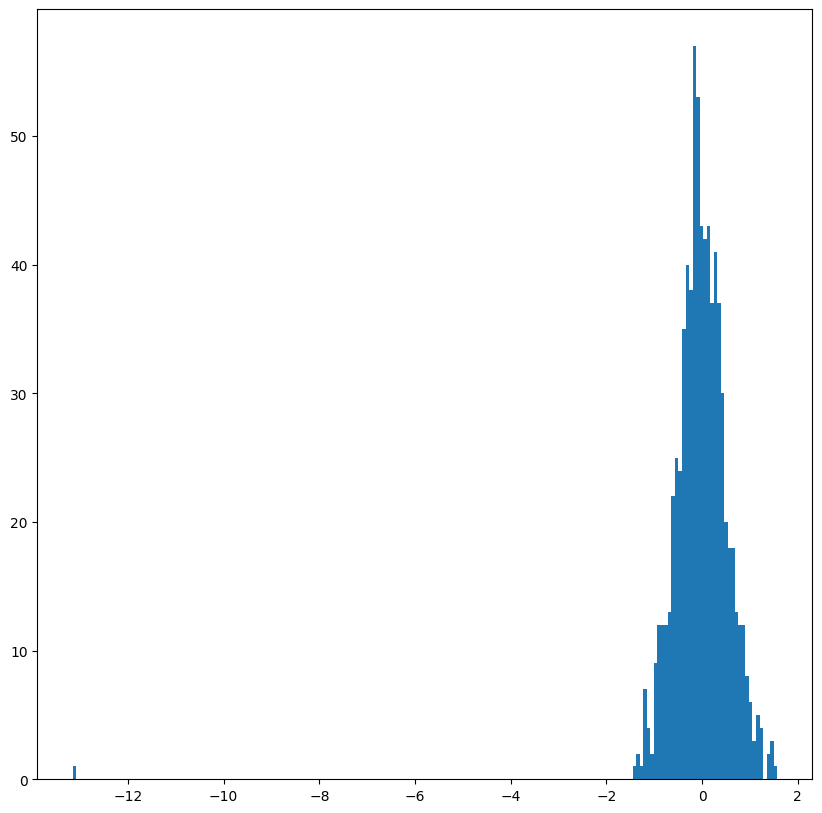

In [16]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

Grouping the values by layer makes sense for the model, but for our purposes we want it grouped by token.

Current dimensions:

[# layers, # batches, # tokens, # features]

Desired dimensions:

[# tokens, # layers, # features]

Luckily, PyTorch includes the permute function for easily rearranging the dimensions of a tensor.

However, the first dimension is currently a Python list!

In [17]:
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 22, 768])


In [18]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 22, 768])

In [19]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 22, 768])

In [20]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([22, 13, 768])

Creating word and sentence vectors from hidden states
Now, what do we do with these hidden states? We would like to get individual vectors for each of our tokens, or perhaps a single vector representation of the whole sentence, but for each token of our input we have 13 separate vectors each of length 768.

In order to get the individual vectors we will need to combine some of the layer vectors…but which layer or combination of layers provides the best representation?

Unfortunately, there’s no single easy answer… Let’s try a couple reasonable approaches, though. Afterwards, I’ll point you to some helpful resources which look into this question further.

Word Vectors
To give you some examples, let’s create word vectors two ways.

First, let’s concatenate the last four layers, giving us a single word vector per token. Each vector will have length 4 x 768 = 3,072.



In [21]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))


Shape is: 22 x 3072


As an alternative method, let’s try creating the word vectors by summing together the last four layers.

In [22]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 22 x 768


Sentence Vectors
To get a single vector for our entire sentence we have multiple application-dependent strategies, but a simple approach is to average the second to last hiden layer of each token producing a single 768 length vector.

In [23]:
# `hidden_states` has shape [13 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

In [24]:
print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


Confirming contextually dependent vectors
To confirm that the value of these vectors are in fact contextually dependent, let’s look at the different instances of the word “bank” in our example sentence:

“After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank.”

Let’s find the index of those three instances of the word “bank” in the example sentence.

In [25]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


They are at 6, 10, and 19.

For this analysis, we’ll use the word vectors that we created by summing the last four layers.

We can try printing out their vectors to compare them.

In [26]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs_sum[6][:5]))
print("bank robber  ", str(token_vecs_sum[10][:5]))
print("river bank   ", str(token_vecs_sum[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    tensor([ 3.3596, -2.9805, -1.5421,  0.7065,  2.0031])
bank robber   tensor([ 2.7359, -2.5577, -1.3094,  0.6797,  1.6633])
river bank    tensor([ 1.5267, -0.8895, -0.5152, -0.9298,  2.8334])


We can see that the values differ, but let’s calculate the cosine similarity between the vectors to make a more precise comparison.

In [27]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[19])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.94
Vector similarity for *different* meanings:  0.69


Pooling Strategy & Layer Choice
Below are a couple additional resources for exploring this topic.

BERT Authors

The BERT authors tested word-embedding strategies by feeding different vector combinations as input features to a BiLSTM used on a named entity recognition task and observing the resulting F1 scores.

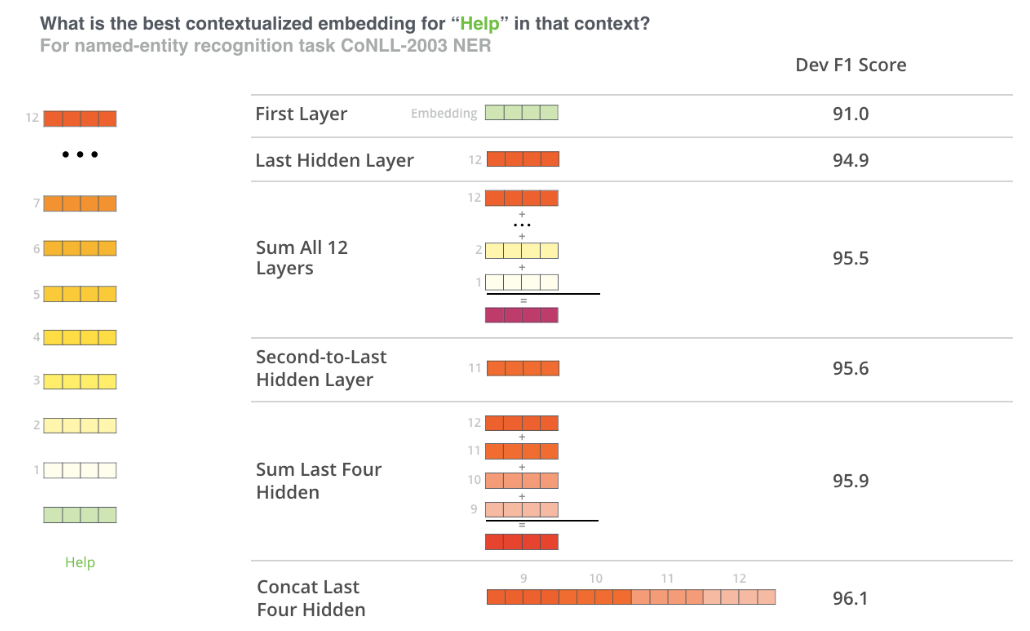

While concatenation of the last four layers produced the best results on this specific task, many of the other methods come in a close second and in general it is advisable to test different versions for your specific application: results may vary.

This is partially demonstrated by noting that the different layers of BERT encode very different kinds of information, so the appropriate pooling strategy will change depending on the application because different layers encode different kinds of information.

Han Xiao’s BERT-as-service

Han Xiao created an open-source project named bert-as-service on GitHub which is intended to create word embeddings for your text using BERT. Han experimented with different approaches to combining these embeddings, and shared some conclusions and rationale on the FAQ page of the project.

bert-as-service, by default, uses the outputs from the second-to-last layer of the model.

I would summarize Han’s perspective by the following:

The embeddings start out in the first layer as having no contextual information (i.e., the meaning of the initial ‘bank’ embedding isn’t specific to river bank or financial bank).
As the embeddings move deeper into the network, they pick up more and more contextual information with each layer.
As you approach the final layer, however, you start picking up information that is specific to BERT’s pre-training tasks (the “Masked Language Model” (MLM) and “Next Sentence Prediction” (NSP)).
What we want is embeddings that encode the word meaning well…
BERT is motivated to do this, but it is also motivated to encode anything else that would help it determine what a missing word is (MLM), or whether the second sentence came after the first (NSP).
The second-to-last layer is what Han settled on as a reasonable sweet-spot.
